# PJT Musique x Machine Learing : Réduction de bruit

### L'objectif de ce PJT a été de produire un code à même de réduire le bruit de fond sur une piste audio, en préservant le signal principal.

#### Pour ce faire, nous avons été aiguillé par l'article suivant : https://ichi.pro/fr/suppression-du-bruit-a-l-aide-du-deep-learning-121691666257977
#### La base de donnée est disponible à l'adresse suivante : https://datashare.ed.ac.uk/handle/10283/1942 
#### Le principe est d'entrainer un réseau de neurones en essayant de ne minimiser la valeur suivante : 
<p style="text-align:center; font-style:italic; font-size:10px;">
    <img src="IMG/abs.PNG" ><br>
  

#### Où Ytrue représente le signal pur, et Ypred représente le signal bruité et corrigé par le réseau.

## 1) Importation des bibliothèques et chargement de la banque de sons

#### on utilise les bibliothèques classiques (tensorflow, numpy, matplotlib). IPython et librosa serve à traiter les sons. 
#### La seule "difficulté" est venue de Conv1DTranspose. En effet, le développeur du code source n'a pas indiqué les versions de ses bibliothèques, et le téléchargement des bibliothèques de façon brute fait que la fonction n'est pas présente. Après une recherche sur internet, il se trouve que le problème est partagé par plusieurs personnes et la solution trouvée a été de "coder" la fonction.

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Concatenate,Input
import numpy as np
import IPython.display
import glob
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio


#class Conv1DTranspose(tf.keras.layers.Layer):   #il se trouve que conv1Dtranspose n'existe pas (plus) dans tf.keras.layers
#    def __init__(self, filters, kernel_size, strides=1, padding='valid'):
#        super().__init__()
#        self.conv2dtranspose = tf.keras.layers.Conv2DTranspose(
#          filters, (kernel_size, 1), (strides, 1), padding
#        )
#
#    def call(self, x):
#        x = tf.expand_dims(x, axis=2)
#        x = self.conv2dtranspose(x)
#        x = tf.squeeze(x, axis=2)
 #       return x

#### Après avoir importé tous les répertoires on va chercher à obtenir les chemins d'accès à tous les échantillons.

In [3]:
clean_sounds = glob.glob('echantillon/CleanData/*')  #Renvoie une liste de chemin d'accès au dossier indiqué
noisy_sounds = glob.glob('echantillon/NoisyData/*')

len(clean_sounds)

11572

## 2) Arrangement des échantillons en un set exploitable  

#### On va ensuite faire les listes de sons "purs" et "sales", en décodant les .wav dans un format usitable par tensorflow

#### On limite ici à 5000 le nombre d'échantillon décodé dans un soucis de rapidité d'éxécution. En effet, rien que pour faire interpréter la partie 2) cela va nécessiter au moins une vingtaine de minutes (sur mon pc à tout le moins).

In [4]:
clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
#transforme les samples en tenseur, le ",_" permet de ne pas prendre le deuxième objet retourné

for i in tqdm(clean_sounds[1:5000]): #tqdm(clean_sounds[1:]):  #tqdm montre la progression du parcours
    so,_ = tf.audio.decode_wav(tf.io.read_file(i)) #,desired_channels=1)
    clean_sounds_list = tf.concat((clean_sounds_list,so),0)

print("premier for terminé") #test pour vérifier l'execution



  0%|          | 0/4999 [00:00<?, ?it/s]

premier for terminé


In [5]:
noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)
for i in tqdm(noisy_sounds[1:5000]): # tqdm(noisy_sounds[1:]):         
    so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
    noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

print(clean_sounds_list.shape,noisy_sounds_list.shape)



  0%|          | 0/4999 [00:00<?, ?it/s]

(232630602, 1) (232630602, 1)


#### On segmente ici les sets d'entrainement, c'est à dire que l'on crée le set train puis test, avec les versions "propres et sales"

In [6]:
batching_size = 12000 #12000 non modifié car je ne connais pas son influence globale

clean_train,noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
    clean_train.append(clean_sounds_list[i:i+batching_size])
    noisy_train.append(noisy_sounds_list[i:i+batching_size])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

print(clean_train.shape,noisy_train.shape)

def get_dataset(x_train,y_train):
    dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
    dataset = dataset.shuffle(100).batch(64,drop_remainder=True)
    return dataset
  
train_dataset = get_dataset(noisy_train[:4000],clean_train[:4000]) #que des 40000
test_dataset = get_dataset(noisy_train[4000:],clean_train[4000:])

  0%|          | 0/19385 [00:00<?, ?it/s]

(19385, 12000, 1) (19385, 12000, 1)


#### On visualise ici un échantillon, on observe nettement les différences sur les phase de "silence" de la piste orange (sans amplitude).

In [ ]:
librosa.display.waveplot(np.squeeze(noisy_train[4].numpy(),axis=-1),label="son sale")
librosa.display.waveplot(np.squeeze(clean_train[4].numpy(),axis=-1),label="son propre")
plt.legend()
plt.show()

## 3) Architecture du réseau de neurone et premier entrainement

#### On suit l'architecture proposé sur le site internet.

In [11]:
inp = Input(shape=(batching_size,1)) #batching_size à la place de 12000
c1 = Conv1D(2,32,2,'same',activation='relu')(inp)
c2 = Conv1D(4,32,2,'same',activation='relu')(c1)
c3 = Conv1D(8,32,2,'same',activation='relu')(c2)
c4 = Conv1D(16,32,2,'same',activation='relu')(c3)
c5 = Conv1D(32,32,2,'same',activation='relu')(c4)

dc1 = Conv1DTranspose(32,32,1,padding='same')(c5)
conc = Concatenate()([c5,dc1])
dc2 = Conv1DTranspose(16,32,2,padding='same')(conc)
conc = Concatenate()([c4,dc2])
dc3 = Conv1DTranspose(8,32,2,padding='same')(conc)
conc = Concatenate()([c3,dc3])
dc4 = Conv1DTranspose(4,32,2,padding='same')(conc)
conc = Concatenate()([c2,dc4])
dc5 = Conv1DTranspose(2,32,2,padding='same')(conc)
conc = Concatenate()([c1,dc5])
dc6 = Conv1DTranspose(1,32,2,padding='same')(conc)
conc = Concatenate()([inp,dc6])
dc7 = Conv1DTranspose(1,32,1,padding='same')(conc)  #,activation='linear')(conc)

#problème ici avec activation (dernière solution : le supprimer)(fonctionne à priori)

model_test = tf.keras.models.Model(inp,dc7)
model_test.summary()

model_test.compile(optimizer=tf.keras.optimizers.Adam(0.002),loss=tf.keras.losses.MeanAbsoluteError())
history_test = model_test.fit(train_dataset,epochs=5) #c'est très long avec : epochs=20)

# à priori l'entrainement se passe bien


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 12000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 6000, 2)      66          input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 3000, 4)      260         conv1d_15[0][0]                  
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 1500, 8)      1032        conv1d_16[0][0]                  
______________________________________________________________________________________________

#### On visualise l'architecture.

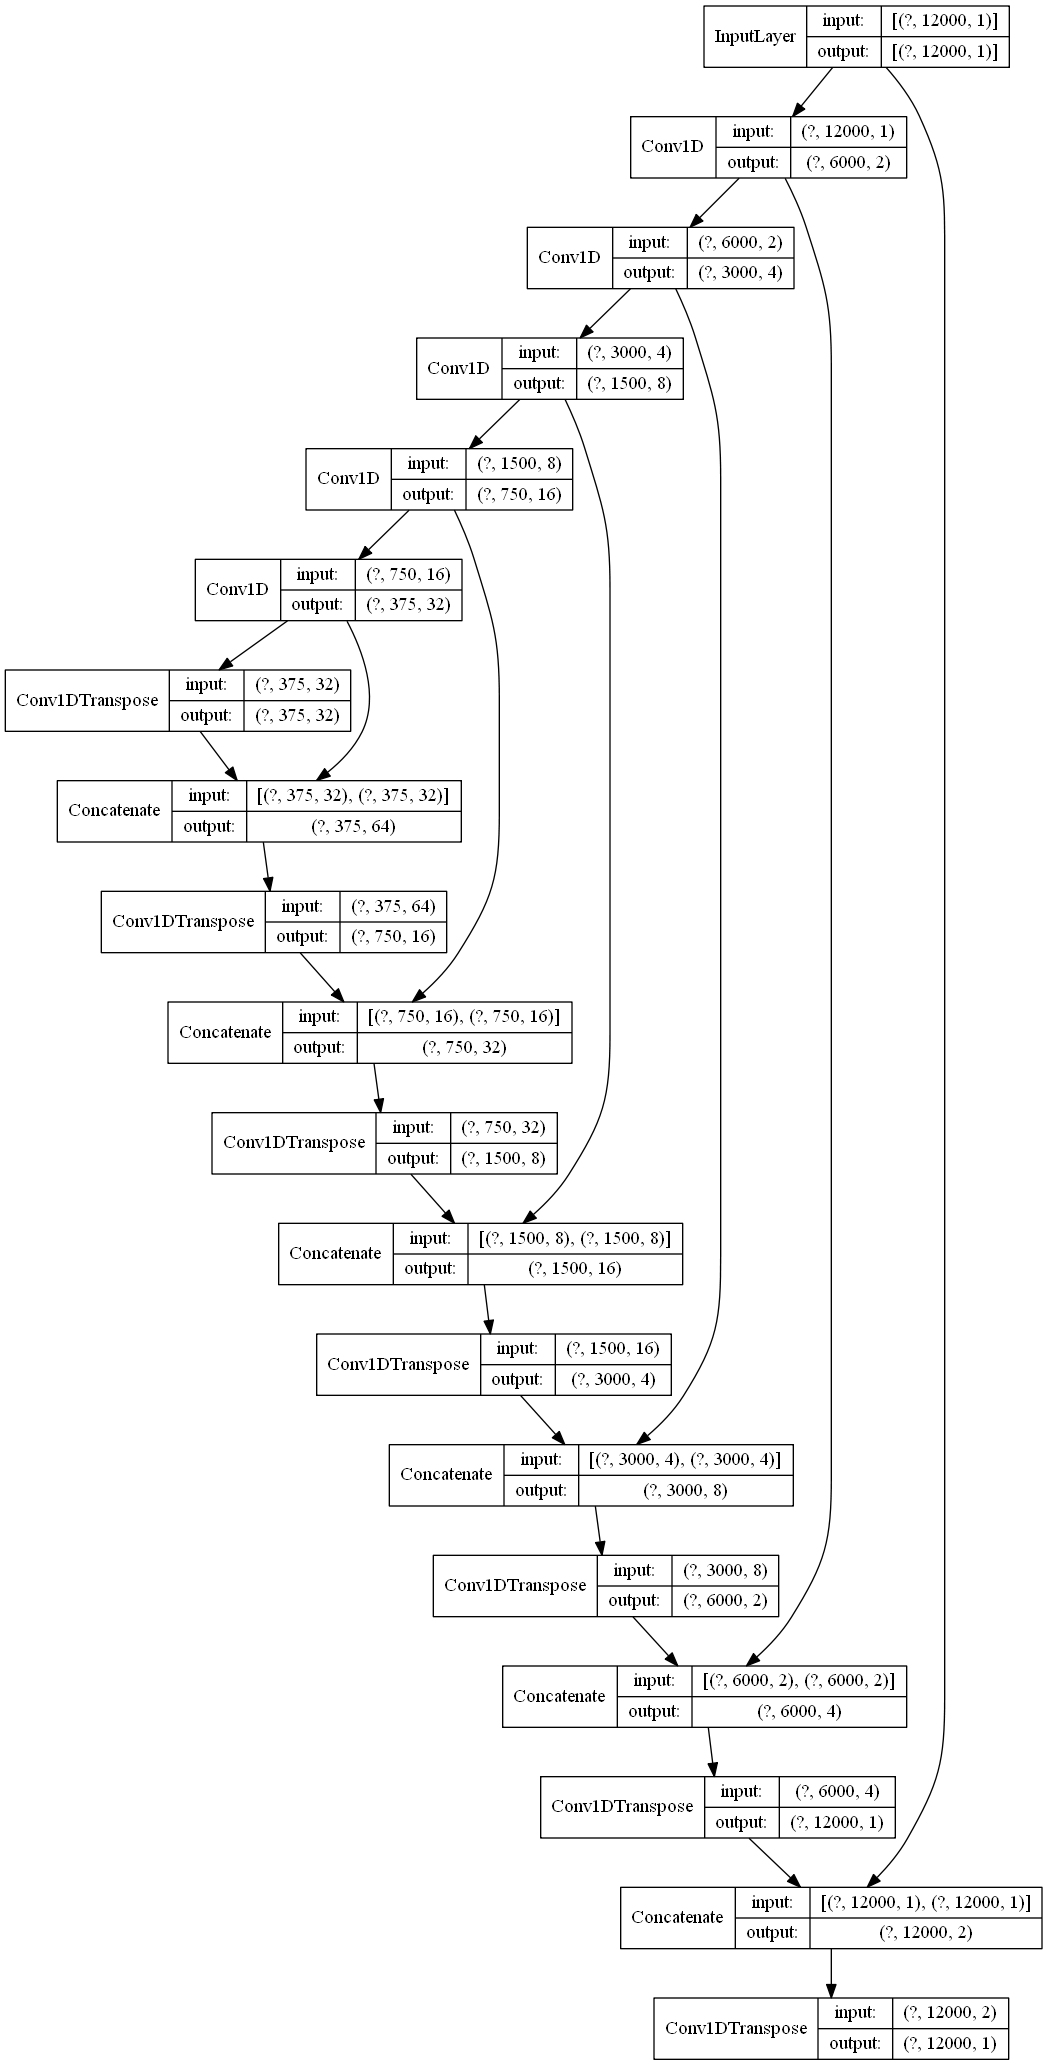

In [15]:
tf.keras.utils.plot_model(model_test,show_shapes=True,show_layer_names=False)

## 4) Visualisation du premier entrainement

#### On code au préalable les fonctions permettant, de convertir, adapter et utiliser les échantillons sons, à la base en .wav, avec le modèle.

In [12]:

def get_audio(path):
    audio,_ = tf.audio.decode_wav(tf.io.read_file(path),1)
    return audio

def inference_preprocess(path):
    audio = get_audio(path)
    audio_len = audio.shape[0]
    batches = []
    for i in range(0,audio_len-batching_size,batching_size):
        batches.append(audio[i:i+batching_size])

    batches.append(audio[-batching_size:])
    diff = audio_len - (i + batching_size)  # Calculation of length of remaining waveform
    return tf.stack(batches), diff

def predict(path,model):
    test_data,diff = inference_preprocess(path)
    predictions = model.predict(test_data)
    final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))  # Reshape the array to get complete frames
    final_op = tf.concat((final_op,predictions[-1][-diff:]),axis=0)  # Concat last, incomplete frame to the rest
    return final_op




#### Reste à modéliser sur un graphique temporel le résultat de l'entrainement.

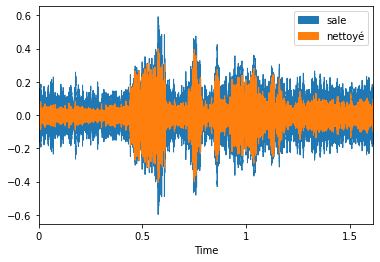

In [50]:
a = 4500 #19
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[a]).numpy(),-1),label="sale")
librosa.display.waveplot(np.squeeze(predict(noisy_sounds[a],model_test)),label="nettoyé")
librosa.display.waveplot(np.squeeze(get_audio(clean_sounds[a]).numpy(),-1),label="propre")
plt.legend()
plt.show()

#### Sur le graphe, on observe une influence bénéfique nette. Cela étant le signal "nettoyé" garde l'allure du signal bruité et reste éloigné du son propre. En somme, il faut améliorer l'entrainement !
#### Sauvegardons tout de même l'entrainement, le code mettant à mal les capacités du PC, les risques qu'il crash sont élevés.

In [7]:
import os
# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("models"): os.mkdir("models")

# sauvegarder structure réseau + poids :
key = 'conv_trained'
model.save('models/'+key) 

# afficher les fichiers créés:
files=[os.path.join("models",f) for f in os.listdir("models") if f.startswith(key)]
for f in files: print(f)

2022-01-12 16:41:03,274 [14464] WARNING  tensorflow:506: [JupyterRequire] From D:\miniconda\envs\minfo\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


models\conv_trained


## 5) Amélioration de l'entrainement

#### La piste la plus évidente pour améliorer l'entrainement est de traiter plus d'échantillon et de faire un nombre plus élevé d'étape d'entrainement.
#### On charge ici un modèle entrainé avec 5000 échantillons et un epoch de 50.

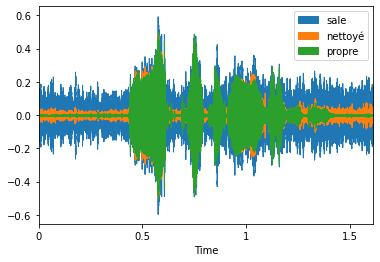

In [38]:
a = 4500
model =tf.keras.models.load_model('models/conv_trained_3')
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[a]).numpy(),-1),label="sale")
librosa.display.waveplot(np.squeeze(predict(noisy_sounds[a],model)),label="nettoyé")
librosa.display.waveplot(np.squeeze(get_audio(clean_sounds[a]).numpy(),-1),label="propre")
plt.legend()
plt.show()

#### Ainsi, l'expérience est bénéfique sans que ça ne soit encore parfait.
#### Afin de rendre compte de l'influnce concrète du code, on va écouter les échantillons et manipulations sous jacentes.

In [28]:
Audio(np.squeeze(get_audio(noisy_sounds[a])),rate=16000)

In [29]:
Audio(np.squeeze(get_audio(clean_sounds[a])),rate=16000)

In [31]:
Audio(np.squeeze(predict(noisy_sounds[a],model)),rate=16000)

#### Il est clair que ce n'est pas encore suffisant. Il faut augmenter le nombre d'échantillon traités.

#### Dans le code source, le développeur a encore modifié la fonction predict en utilisant des bibliothèques optimisées en temps de traitement. On montre ici l'execution de ce nouvel outil.

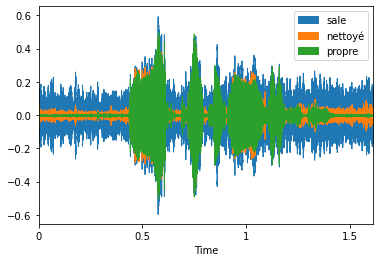

In [47]:
lite_model = tf.lite.TFLiteConverter.from_keras_model(model)
lite_model.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = lite_model.convert()

with open('TFLiteModel.tflite','wb') as f:
  f.write(tflite_model_quant)
#TFLite
interpreter = tf.lite.Interpreter(model_path='TFLiteModel.tflite')
interpreter.allocate_tensors()

def predict_tflite(path):
    test_audio,diff = inference_preprocess(path)
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    preds = []
    for i in test_audio:
        interpreter.set_tensor(input_index, tf.expand_dims(i,0))
        interpreter.invoke()
        predictions = interpreter.get_tensor(output_index)
        preds.append(predictions)

    predictions = tf.squeeze(tf.stack(preds,axis=1))
    final_op = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
    final_op = tf.concat((tf.squeeze(final_op),predictions[-1][-diff:]),axis=0)
    return final_op

librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[a]).numpy(),-1),label='sale')
librosa.display.waveplot(predict_tflite(noisy_sounds[a]).numpy(),label="nettoyé")
librosa.display.waveplot(np.squeeze(get_audio(clean_sounds[a]).numpy(),-1),label="propre")
plt.legend()
plt.show()

#### Le résultat n'est pas différend et le temps de traitement d'un échantillon n'était pas un problème jusqu'alors. La manipulation n'a donc rien de pertinent en l'état.

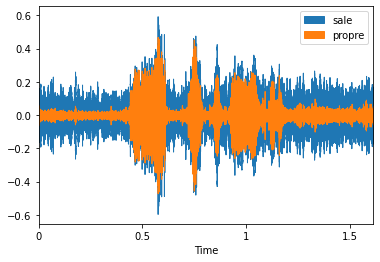

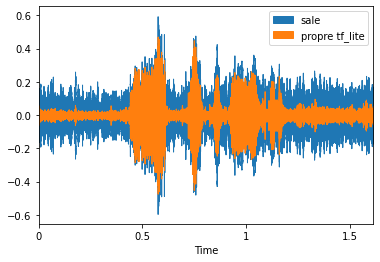

In [48]:
a = 4500 #19
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[a]).numpy(),-1),label="sale")
librosa.display.waveplot(np.squeeze(predict(noisy_sounds[a],model)),label="propre")
plt.legend()
plt.show()

librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[a]).numpy(),-1),label="sale")
librosa.display.waveplot(np.squeeze(predict_tflite(noisy_sounds[a]).numpy()),label="propre tf_lite")
plt.legend()
plt.show()


# ZONE DE TESTS ET ENTRAINEMENTS

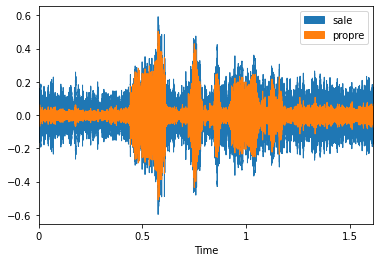

In [20]:
i=1
b=plt.figure('60 epoch, 5000 ech train')
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[a]).numpy(),-1),label="sale")
librosa.display.waveplot(np.squeeze(predict(noisy_sounds[a])),label="propre")
plt.legend()
plt.savefig("test"+str(i))
i+=1

In [39]:
hist = model.fit(train_dataset,epochs=10)


Train for 62 steps
Epoch 1/10
62/62 [==============================] - 102s 2s/step - loss: 0.0106
Epoch 2/10
62/62 [==============================] - 99s 2s/step - loss: 0.0105
Epoch 3/10
62/62 [==============================] - 98s 2s/step - loss: 0.0105
Epoch 4/10
62/62 [==============================] - 98s 2s/step - loss: 0.0105
Epoch 5/10
62/62 [==============================] - 98s 2s/step - loss: 0.0105
Epoch 6/10
62/62 [==============================] - 98s 2s/step - loss: 0.0105
Epoch 7/10
62/62 [==============================] - 98s 2s/step - loss: 0.0105
Epoch 8/10
62/62 [==============================] - 98s 2s/step - loss: 0.0105
Epoch 9/10
62/62 [==============================] - 98s 2s/step - loss: 0.0105
Epoch 10/10
62/62 [==============================] - 98s 2s/step - loss: 0.0105
Train for 62 steps
Epoch 1/10
62/62 [==============================] - 98s 2s/step - loss: 0.0104
Epoch 2/10
62/62 [==============================] - 98s 2s/step - loss: 0.0104
Epoch 3/10
6

In [40]:
import os
# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("models"): os.mkdir("models")

# sauvegarder structure réseau + poids :
key = 'conv_trained_4'
model.save('models/'+key) 

# afficher les fichiers créés:
files=[os.path.join("models",f) for f in os.listdir("models") if f.startswith(key)]
for f in files: print(f)

models\conv_trained_4


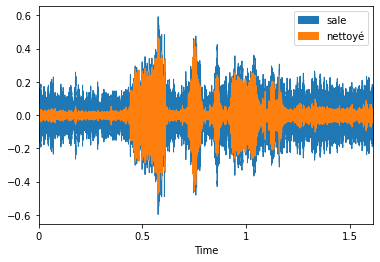

In [49]:
a=4500
i=2

b=plt.figure('300 epoch, 5000 ech train')
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[a]).numpy(),-1),label="sale")
librosa.display.waveplot(np.squeeze(predict(noisy_sounds[a],model)),label="nettoyé")
#librosa.display.waveplot(np.squeeze(get_audio(clean_sounds[a]).numpy(),-1),label="propre")
plt.legend()
plt.savefig("test"+str(i))
i+=1

In [43]:
Audio(np.squeeze(get_audio(noisy_sounds[a])),rate=16000)

In [45]:
Audio(np.squeeze(predict(noisy_sounds[a],model)),rate=16000)